code to predict pv generation

In [153]:
# env - model-run-tf_env Python 3.10.16

import numpy as np
import pandas as pd
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator # To ensure demand axis are integer.

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import statsmodels.api as sm

# Third party packages.
import os                       # Execute tasks related to your operating system.
import polars as pl
import pickle                   # Save and load data to and from pickle files.
import time
import json
import os
import joblib

from datetime import datetime

import time


Data Understanding

Load data set. Split with 80% and 20% split

In [154]:
# Replace 'your_file.xls' with your actual file name or path
df_hr_orig_data = pd.read_excel('../../data/HRIS_extract_addY.xlsx')

# Display the DataFrame
print(df_hr_orig_data.head())

# Show a sample of first 3 rows.
df_hr_orig_data.head(3)

df_pd_orig = df_hr_orig_data


      Unnamed: 0 Snapshot_Date  Employee_ID  Team_ID  Gender  Age  Hire_date  \
0  2011000000153    2011-01-01          153        1    Male   39 2003-01-01   
1  2011000000158    2011-01-01          158        1  Female   38 2001-06-01   
2  2011000000159    2011-01-01          159        1  Female   42 1994-05-01   
3  2011000000162    2011-01-01          162        1    Male   36 2002-04-01   
4  2011000000163    2011-01-01          163        1    Male   39 2004-01-01   

   Tenure  Job_Level  Salary  Distance_from_work  Days_absent  \
0       8          6   65298                  23            0   
1      10          8   80780                  72            7   
2      17          8   73284                  96            8   
3       9          9   94401                  67            0   
4       7          6   46853                  89            0   

   Performance_Rating Potential_Rating  Turnover     Retirement  \
0                 4.0              Low     False  No Retireme

Descriptive Statistics

In [155]:
# Using Pandas.
df_pd_num = df_pd_orig.select_dtypes(include='number')

# Column names (Pandas: df_pd_orig_num.columns.tolist()).
l_df_num_names = df_pd_num.columns
print(f"We have {len(l_df_num_names)} numerical variables:\n{l_df_num_names}")

# Convert to datetime format
df_pd_orig_str = df_pd_orig.select_dtypes(include='object')
print("Number of rows:", df_pd_orig_str.shape[0], "and column names are:", df_pd_orig_str.columns, "and column types are:", df_pd_orig_str.dtypes)

We have 12 numerical variables:
Index(['Unnamed: 0', 'Employee_ID', 'Team_ID', 'Age', 'Tenure', 'Job_Level',
       'Salary', 'Distance_from_work', 'Days_absent', 'Performance_Rating',
       'Employee_turnover (Y)', 'Payhouse_Level'],
      dtype='object')
Number of rows: 6109 and column names are: Index(['Gender', 'Potential_Rating', 'Retirement'], dtype='object') and column types are: Gender              object
Potential_Rating    object
Retirement          object
dtype: object


To check if the output column has unique values

In [156]:
l_col = ['Employee_turnover (Y)']

for s_col in l_col:
    print(f"{l_col}: {df_pd_orig[l_col]}")
    print(f"{s_col}: {df_pd_orig[s_col].unique()}")

['Employee_turnover (Y)']:       Employee_turnover (Y)
0                         0
1                         0
2                         0
3                         0
4                         0
...                     ...
6104                      0
6105                      0
6106                      0
6107                      0
6108                      0

[6109 rows x 1 columns]
Employee_turnover (Y): [0 1]


Contruct a descriptive summary

In [157]:
df_pd_orig.describe()

,Unnamed: 0,Snapshot_Date,Employee_ID,Team_ID,Age,Hire_date,Tenure,Job_Level,Salary,Distance_from_work,Days_absent,Performance_Rating,Employee_turnover (Y),Payhouse_Level
count,6.109000e+03,6109,6109.000000,6109.000000,6109.000000,6109,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6072.000000,6109.000000,0.0
mean,2.019584e+12,2019-08-02 09:33:44.226551040,823.021116,13.803732,43.065641,2014-11-09 17:08:40.347028992,5.178098,7.939434,87058.577345,62.038632,10.815354,2.965250,0.336553,NaN
min,2.011000e+12,2011-01-01 00:00:00,153.000000,1.000000,26.000000,1991-03-01 00:00:00,1.000000,6.000000,45759.000000,0.000000,0.000000,1.000000,0.000000,NaN
25%,2.017000e+12,2017-01-01 00:00:00,436.000000,5.000000,34.000000,2011-09-01 00:00:00,2.000000,7.000000,71909.000000,33.000000,0.000000,2.000000,0.000000,NaN
50%,2.020000e+12,2020-01-01 00:00:00,746.000000,9.000000,42.000000,2016-03-01 00:00:00,3.000000,8.000000,84447.000000,59.000000,0.000000,3.000000,0.000000,NaN
75%,2.023000e+12,2023-01-01 00:00:00,1151.000000,21.000000,52.000000,2019-11-01 00:00:00,7.000000,9.000000,99620.000000,83.000000,7.000000,4.000000,1.000000,NaN
max,2.024000e+12,2024-01-01 00:00:00,2034.000000,68.000000,68.000000,2023-12-01 00:00:00,33.000000,11.000000,184243.000000,250.000000,365.000000,5.000000,1.000000,NaN
std,3.734608e+09,NaN,471.385590,12.415633,10.289146,NaN,5.391853,1.424801,20238.955875,41.867707,34.426178,1.123246,0.472569,NaN


Function to capture metrics from prediction models

In [158]:
# Custom function for MAPE and sMAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Function to compute AIC for regression models
def compute_aic(y_true, y_pred, num_params):
    residuals = y_true - y_pred
    mse = np.mean(residuals**2)
    n = len(y_true)
    aic = n * np.log(mse) + 2 * num_params  # AIC formula
    return aic

# List to store results
results = []

In [159]:
def handle_datetime_columns(df, drop_original=True):
    
    # Loop through all columns to detect datetime
    datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns

    for col in datetime_cols:
        print(f"Processing datetime column: {col}")

        # Extract parts of date
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df[f'{col}_weekday'] = df[col].dt.weekday
        df[f'{col}_dayofyear'] = df[col].dt.dayofyear

        # Optionally: compute time difference (e.g., tenure in days)
        today = pd.to_datetime('today')
        df[f'{col}_since_today_days'] = (today - df[col]).dt.days

        # Drop original datetime column if requested
        if drop_original:
            df = df.drop(columns=[col])

    return df

def remove_categorical_columns(df):
    # Detect categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    print(f"Categorical columns removed: {list(categorical_cols)}")

    # Drop them
    df_numeric = df.drop(columns=categorical_cols)
    
    return df_numeric



Data Preparation

In [160]:
# Shows the count of NaNs in each column
print(df_pd_orig.isnull().sum())
df_pd_orig = df_pd_orig.dropna(axis=1)

df_pd_orig = handle_datetime_columns(df_pd_orig)
df_pd_orig = remove_categorical_columns(df_pd_orig)


Unnamed: 0                  0
Snapshot_Date               0
Employee_ID                 0
Team_ID                     0
Gender                      0
Age                         0
Hire_date                   0
Tenure                      0
Job_Level                   0
Salary                      0
Distance_from_work          0
Days_absent                 0
Performance_Rating         37
Potential_Rating          675
Turnover                    0
Retirement                  0
Employee_turnover (Y)       0
Payhouse_Level           6109
dtype: int64
Processing datetime column: Snapshot_Date
Processing datetime column: Hire_date
Categorical columns removed: ['Gender', 'Retirement']


/var/folders/gy/xs43v__d0mn25qy5kzxrnkrm0000gn/T/ipykernel_1511/451427579.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_year'] = df[col].dt.year
/var/folders/gy/xs43v__d0mn25qy5kzxrnkrm0000gn/T/ipykernel_1511/451427579.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_month'] = df[col].dt.month


Prepare data for prediction

In [161]:
# Order the combined dataset by 'Hire_date_year' (ascending or descending)
df_pd_orig = df_pd_orig.sort_values(by='Hire_date_year', ascending=True)


# Now, split the combined data back into train and test based on some criteria or the original split.
# Assuming you want 80% for training and 20% for testing, for example:
train_size = int(0.8 * len(df_pd_orig))  # 80% for train
train = df_pd_orig[:train_size]
test = df_pd_orig[train_size:]

# Optionally, check the results to ensure the datasets are correctly split
print("Train data (first few rows):")
print(train.head())

print("Test data (first few rows):")
print(test.head())

# Check for duplicate 'Hire_date_year' values in both datasets
print(f"Train data duplicates: {train['Hire_date_year'].duplicated().sum()}")
print(f"Test data duplicates: {test['Hire_date_year'].duplicated().sum()}")

# Ensure no duplicates
train = train.loc[~train['Hire_date_year'].duplicated()]
test = test.loc[~test['Hire_date_year'].duplicated()]

# Reset the index for both train and test sets
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# Check the resulting datasets
print("Train Data after reset:")
print(train.head())
print("Test Data after reset:")
print(test.head())


Train data (first few rows):
         Unnamed: 0  Employee_ID  Team_ID  Age  Tenure  Job_Level  Salary  \
28    2011000000196          196        3   68      20          7   59599   
2137  2019000000234          234        7   59      28          7   77918   
576   2014000000177          177        2   57      23          7   65060   
607   2014000000234          234        7   54      23          7   63118   
2114  2019000000177          177        2   62      28          7   76977   

      Distance_from_work  Days_absent  Turnover  ...  Snapshot_Date_day  \
28                    80            0      True  ...                  1   
2137                  13           11     False  ...                  1   
576                   71            7     False  ...                  1   
607                   13           19     False  ...                  1   
2114                  71            0     False  ...                  1   

      Snapshot_Date_weekday  Snapshot_Date_dayofyear  \
2

Use of TImeseries split to avoid data leakage. Then perform prediction using regression models

In [162]:
X = df_pd_orig.drop(columns=['Employee_turnover (Y)'])
y = df_pd_orig["Employee_turnover (Y)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_run_start_time = time.time()

# Fit logistic regression
clf = LogisticRegression(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Results
print(classification_report(y_test, y_pred))

model_run_end_time = time.time()

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Store results
results.append(["Logistics Regression Model", 
                execution_time])



              precision    recall  f1-score   support

           0       0.76      0.56      0.64       828
           1       0.40      0.62      0.49       394

    accuracy                           0.58      1222
   macro avg       0.58      0.59      0.57      1222
weighted avg       0.64      0.58      0.59      1222



GridSearchCV model

In [163]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

model_run_start_time = time.time()

# Define your model
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100],
    'max_depth': [5]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',
    cv=3,     # 3-fold cross-validation
    n_jobs=1,  # Single-threaded to avoid multiprocessing errors
    verbose=2
)

# Run the search
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)

# Optionally, evaluate on the test set if you have X_test, y_test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

model_run_end_time = time.time()

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time


# Store results
results.append(["GridSearchCV Model", 
                execution_time])



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.3s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.5s
Best Parameters: {'max_depth': 5, 'n_estimators': 100}
Best F1 Score (CV): 0.7391878075791155
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.81      0.85       828
           1       0.67      0.80      0.73       394

    accuracy                           0.81      1222
   macro avg       0.78      0.81      0.79      1222
weighted avg       0.82      0.81      0.81      1222



Naive Model

In [164]:
# Step 7: Naive Forecast - last value of training set as prediction

from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

model_run_start_time = time.time()

# Create a naive model that always predicts the most frequent class
naive_model = DummyClassifier(strategy='most_frequent', random_state=42)

# Train the model
naive_model.fit(X_train, y_train)

# Make predictions
y_pred_naive = naive_model.predict(X_test)

# Evaluate the model
print("Naive Model Accuracy:", accuracy_score(y_test, y_pred_naive))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_naive))

model_run_end_time = time.time()

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Store results
results.append(["Naive Model", 
                execution_time])


Naive Model Accuracy: 0.6775777414075287

Classification Report:

              precision    recall  f1-score   support

           0       0.68      1.00      0.81       828
           1       0.00      0.00      0.00       394

    accuracy                           0.68      1222
   macro avg       0.34      0.50      0.40      1222
weighted avg       0.46      0.68      0.55      1222



/opt/miniconda3/envs/warp-prediction-model/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/warp-prediction-model/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/warp-prediction-model/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Predict using decision tree regression

In [165]:

# Train Decision Tree Regressor Model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_run_start_time = time.time()

# Define the model (Decision Tree Regressor)
dt_regressor = DecisionTreeRegressor(random_state=42)

# Train the model on your training data
dt_regressor.fit(X_train, y_train)

# Predict on the test data
y_pred = dt_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Decision Tree Regression Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")


model_run_end_time = time.time()

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_pred, "Diff": y_test.values - y_pred})

# Store results
results.append(["Decision Tree", 
                execution_time])

                

Decision Tree Regression Metrics:
Mean Squared Error (MSE): 0.09
Mean Absolute Error (MAE): 0.09
R-squared (R2): 0.58
Mean Absolute Error: 0.09165302782324058


Predit using Random Forest regressor

In [166]:
# Train Random Forest Regressor Model
model_run_start_time = time.time()

# Make Predictions
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int
model_run_end_time = time.time()

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Print Predictions
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Store results
results.append(["Random Forest", 
                execution_time])


Mean Absolute Error: 0.14616612111292962


Survival


   Hire_date_year  duration  survival_probability
0            2020         5                   NaN
1            2021         4                   NaN
2            2022         3                   1.0
3            2023         2                   1.0
Model run time: 0.02 seconds


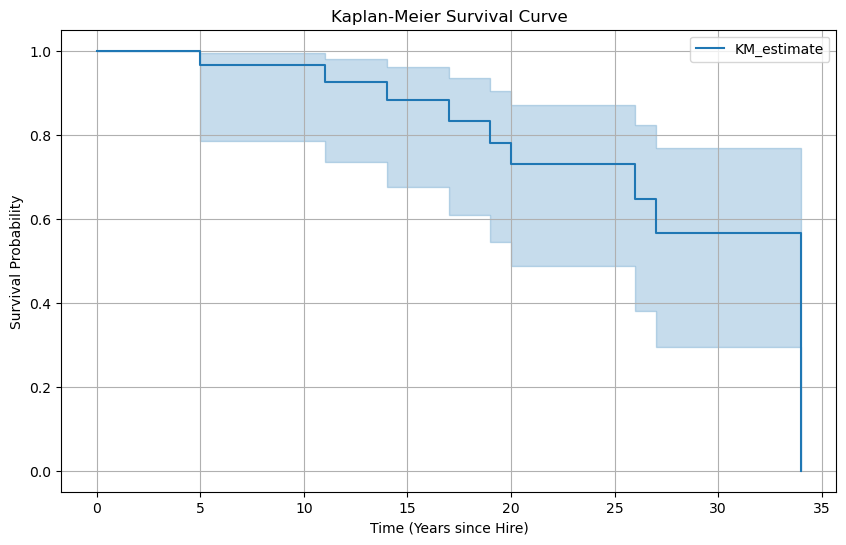

In [167]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import time

# Define today's year or a censoring reference year (e.g., '2025')
today_year = pd.to_datetime('2025-05-10').year
# Recalculate 'duration' for train and test (if not already done)
train['duration'] = today_year - train['Hire_date_year']
test['duration'] = today_year - test['Hire_date_year']

# Start the timer to track model execution time
model_run_start_time = time.time()

# Ensure that the columns are numeric
train['duration'] = pd.to_numeric(train['duration'], errors='coerce')
test['duration'] = pd.to_numeric(test['duration'], errors='coerce')

# Initialize Kaplan-Meier Fitter
kmf = KaplanMeierFitter()
# Fit the Kaplan-Meier model to the training data
kmf.fit(durations=train['duration'], event_observed=train['Employee_turnover (Y)'])

# Predict survival probabilities for the test data
test['survival_probability'] = kmf.predict(test['duration'])

# Show a sample of the test data with the predicted survival probabilities
print(test[['Hire_date_year', 'duration', 'survival_probability']].head())

# End the timer to calculate execution time
model_run_end_time = time.time()
execution_time = model_run_end_time - model_run_start_time

print(f"Model run time: {execution_time:.2f} seconds")

# Plot the Kaplan-Meier survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time (Years since Hire)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

# Optionally, store results (if you have a list named 'results')
results.append(["Kaplan-Meier", execution_time])


Print Model evaluation results

In [168]:
# Convert results to DataFrame
metrics_df = pd.DataFrame(results, columns=["Model", "Execution Time"])

metrics_df['Comments'] = 'First Model Run'

# Display Table
print(metrics_df)

# Define the filename
model_run_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_results_file_path = 'ned-model-results_f{model_run_timestamp}.csv'

# Step 10: Check if file exists, then append or create
if os.path.exists(model_results_file_path):
    # Append to existing file
    existing_results = pd.read_csv(model_results_file_path)
    updated_results = pd.concat([existing_results, metrics_df], ignore_index=True)
    updated_results.to_csv(model_results_file_path, index=False)
else:
    # Create new file
    metrics_df.to_csv(model_results_file_path, index=False)

print(f"✅ Model evaluation saved to {model_results_file_path}")

                        Model  Execution Time         Comments
0  Logistics Regression Model        0.058241  First Model Run
1          GridSearchCV Model        1.757175  First Model Run
2                 Naive Model        0.023955  First Model Run
3               Decision Tree        0.057842  First Model Run
4               Random Forest      120.683720  First Model Run
5                Kaplan-Meier        0.015950  First Model Run
✅ Model evaluation saved to ned-model-results_f{model_run_timestamp}.csv
